# Skin Conditions Model 
This model is the model that used to classify user's skin conditions and have an output of multi-label class from 3 possible class (acne,eye_bags, redness)

## Import Libraries, Mobilenet, and Env File

In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [2]:
# Importing Env File
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH_CONDITIONS_2')
models_path = os.getenv('MODELS_PATH')

In [3]:
# Importing MobileNetV2 with ImageNet weights without the top layer
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [18]:
# Membekukan semua lapisan dari model MobileNet
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Fine-tuning: Membuka beberapa lapisan terakhir dari MobileNet
for layer in base_model.layers[-5:]:  # Mengatur lebih banyak lapisan terakhir dapat dilatih
    layer.trainable = True

## Importing Trained Model (If Exist)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(models_path + 'skin_conditions_model.h5')

## Import Data and Data Augmentation

In [6]:
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import random

class SkinConditionsDataset(tfds.core.GeneratorBasedBuilder):
    """DatasetBuilder for skin condition detection."""

    VERSION = tfds.core.Version('1.0.0')
    MANUAL_DOWNLOAD_INSTRUCTIONS = "Please ensure the skin type dataset is downloaded and located at the right path (look at env file)"

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description=("Dataset for skin conditions classification with 2 labels: acne n eye_bags"),
            features=tfds.features.FeaturesDict({
                'image': tfds.features.Image(shape=(224, 224, 3)),
                'label': tfds.features.Tensor(shape=(3,), dtype=tf.float32),
            }),
            supervised_keys=('image', 'label'),
        )

    def _split_generators(self, dl_manager):
        path = dl_manager.manual_dir
        
        # Membaca semua gambar dan label
        all_data = []
        for category in ['acne', 'eye_bags', 'normal']:
            category_path = os.path.join(path, category)
            for filename in os.listdir(category_path):
                all_data.append((filename, category))

        # Membuat DataFrame
        df = pd.DataFrame(all_data, columns=['filename', 'label'])

        # Membagi data menjadi train, val, dan test
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  

        return {
            'train': self._generate_examples(train_df, path),
            'val': self._generate_examples(val_df, path),
            'test': self._generate_examples(test_df, path),
        }

    def _generate_examples(self, dataframe, base_path):
        label_map = {
            'acne': [1, 0, 0],
            'eye_bags': [0, 1, 0],
            'normal': [0, 0, 1]
        }
        images_labels = []

        # Load images and their labels
        for _, row in dataframe.iterrows():
            image_path = os.path.join(base_path, row['label'], row['filename'])
            image = tf.io.read_file(image_path)  
            image = tf.io.decode_image(image, channels=3)  
            image = tf.image.resize(image, (224, 224)) 
            image = tf.cast(image, tf.uint8)  
            label = tf.cast(label_map[row['label']], tf.float32)  
            images_labels.append((image, label))  

        # Generate standard examples
        for i, (image, label) in enumerate(images_labels):
            yield f"{label.numpy()}_{i}", {  
                'image': image.numpy(),
                'label': label.numpy(),  
            }

        # Generate overlay examples
        for i in range(0, len(images_labels), 2): 
            selected_images = images_labels[i:i+2]  
            if len(selected_images) < 2:
                continue  # Skip jika tidak ada cukup gambar dalam kelompok
            
            # Buat variabel untuk menyimpan hasil pengecekan
            contains_normal = any(tf.reduce_all(label == [0, 0, 1]) for _, label in selected_images)

            if contains_normal:
                continue  # Skip kelompok gambar jika ada label "normal"
            
            # Pilih dua gambar acak dari kelompok untuk di-overlay
            random.shuffle(selected_images)
            image1, label1 = selected_images[0]
            image2, label2 = selected_images[1]

            # Pastikan kelas berbeda sebelum overlay
            if tf.reduce_sum(tf.abs(label1 - label2)) > 0:  # Pastikan label berbeda
                # Buat overlay hanya jika label berbeda
                combined_image, combined_label = self.overlay_two_data(image1, label1, image2, label2)
                combined_image = tf.cast(combined_image, tf.uint8)  # Pastikan konversi ke uint8 untuk overlay

                # Buat key unik untuk overlay
                unique_key = f"overlay_{i}_{i+1}"

                # Yield contoh baru untuk dataset
                yield unique_key, {
                    'image': combined_image.numpy(),
                    'label': combined_label.numpy(),  # Pastikan label adalah NumPy array
                }

    # Fungsi untuk menggabungkan dua gambar
    def overlay_two_images(self, image1, image2, alpha=0.5):
        # Resize kedua gambar ke ukuran yang sama
        image1 = tf.image.resize(image1, (224, 224))
        image2 = tf.image.resize(image2, (224, 224))

        # Gabungkan gambar dengan alpha untuk mengatur seberapa banyak kontribusi dari setiap gambar
        combined_image = (image1 * alpha) + (image2 * alpha)

        return combined_image

    # Fungsi untuk overlay dua data (label juga digabung)
    def overlay_two_data(self, image1, label1, image2, label2):
        combined_image = self.overlay_two_images(image1, image2)
        # Gabungkan label dengan mengambil nilai maksimum untuk setiap kelas
        combined_label = tf.maximum(label1, label2)
        return combined_image, combined_label


# Use the updated dataset class
builder = SkinConditionsDataset(data_dir=datasets_path)
builder.download_and_prepare()

## Checking Dataset

In [7]:
ds_train = builder.as_dataset(split='train')
ds_val = builder.as_dataset(split='val')
ds_test = builder.as_dataset(split='test')

In [8]:
# Filter dan tampilkan label dengan nilai [1, 1, 0]
for i, example in enumerate(ds_train):
    label = example['label'].numpy()  
    # print(f"Label {i + 1}: {label}")
    if (label == [1, 1, 0]).all():    
        print(f"Label {i + 1}: {label}")

Label 26: [1. 1. 0.]
Label 34: [1. 1. 0.]
Label 46: [1. 1. 0.]
Label 66: [1. 1. 0.]
Label 70: [1. 1. 0.]
Label 79: [1. 1. 0.]
Label 87: [1. 1. 0.]
Label 96: [1. 1. 0.]
Label 106: [1. 1. 0.]
Label 116: [1. 1. 0.]
Label 141: [1. 1. 0.]
Label 151: [1. 1. 0.]
Label 166: [1. 1. 0.]
Label 174: [1. 1. 0.]
Label 178: [1. 1. 0.]
Label 189: [1. 1. 0.]
Label 202: [1. 1. 0.]
Label 222: [1. 1. 0.]
Label 253: [1. 1. 0.]
Label 259: [1. 1. 0.]
Label 282: [1. 1. 0.]
Label 305: [1. 1. 0.]
Label 310: [1. 1. 0.]
Label 315: [1. 1. 0.]
Label 318: [1. 1. 0.]
Label 326: [1. 1. 0.]
Label 334: [1. 1. 0.]
Label 337: [1. 1. 0.]
Label 351: [1. 1. 0.]
Label 367: [1. 1. 0.]
Label 368: [1. 1. 0.]
Label 371: [1. 1. 0.]
Label 392: [1. 1. 0.]
Label 398: [1. 1. 0.]


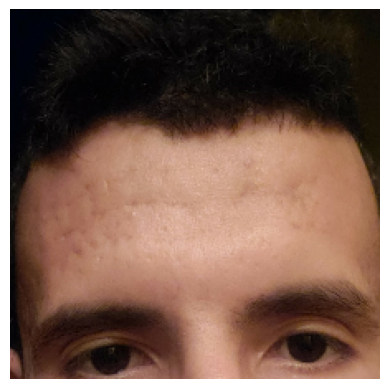

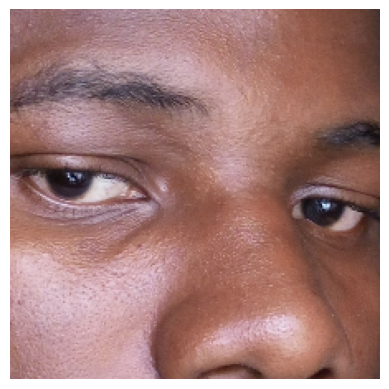

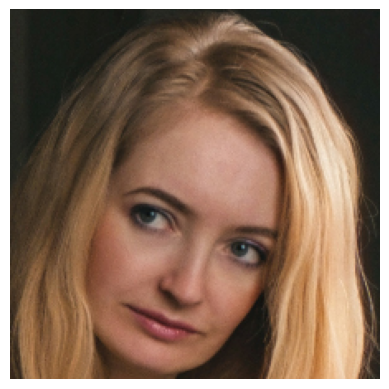

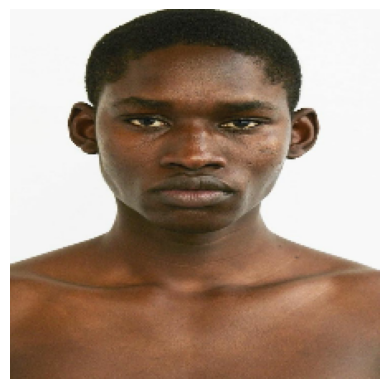

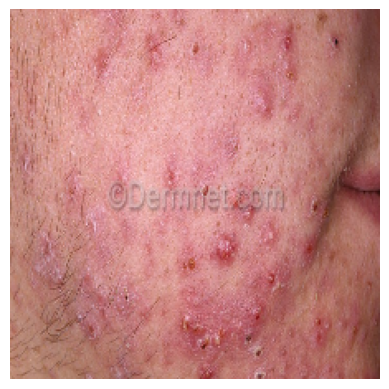

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Fungsi untuk menampilkan gambar
def show_image(image):
    image = image.numpy() 
    plt.imshow(image)
    plt.axis('off')  
    plt.show()

# Fungsi untuk menampilkan beberapa gambar
def show_images_from_dataset(dataset, num_images=5):
    for i, data in enumerate(dataset.take(num_images)): 
        image = data['image']
        # Tampilkan gambar
        show_image(image)

# Menampilkan gambar pertama dari ds_train
show_images_from_dataset(ds_train, num_images=5)


## Loading The Dataset And Data Augmentation

In [9]:
# Memuat dataset yang sudah diproses
ds_train = tfds.load('skin_conditions_dataset', split='train', data_dir=datasets_path)
ds_val = tfds.load('skin_conditions_dataset', split='val', data_dir=datasets_path)
ds_test = tfds.load('skin_conditions_dataset', split='test', data_dir=datasets_path)

In [10]:
def augment_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    scale = tf.random.uniform(shape=[], minval=0.8, maxval=1.2, dtype=tf.float32)
    new_height = tf.cast(scale * 224, tf.int32)
    new_width = tf.cast(scale * 224, tf.int32)
    image = tf.image.resize(image, (new_height, new_width))
    image = tf.image.resize_with_crop_or_pad(image, 224, 224) 
    
    return image, label

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Function to ensure data is paired as (image, label)
def preprocess(data):
    image = data['image']
    label = data['label']
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

# Apply preprocessing and augmentation
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets
ds_train = ds_train.batch(8).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(8).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(8).prefetch(tf.data.AUTOTUNE)

In [12]:
# Hitung jumlah data dalam ds_train
num_samples = sum(1 for _ in ds_train)
# num_samples = sum(1 for _ in ds_train.unbatch())

print(f"Jumlah gambar dan label dalam ds_train: {num_samples}")

Jumlah gambar dan label dalam ds_train: 52


## Creating The Model

In [20]:
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Menambahkan lapisan kustom di atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(128, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)  # ReLU activation setelah batch normalization
x = Dropout(0.5)(x)
outputs = Dense(3, activation='sigmoid', kernel_regularizer=l2(0.01))(x)  # Menggunakan sigmoid untuk multi-label classification

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Menyesuaikan optimizer dan learning rate 
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) 
# # Compiling the model 
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Show Model Architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 884,611 (3.37 MB)

 Non-trainable params: 1,538,240 (5.87 MB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback untuk menghentikan pelatihan jika validasi loss tidak membaik
early_stopping = EarlyStopping(
    monitor='val_loss',                  
    patience=5,                         
    restore_best_weights=True,           
    verbose=1                            
)

# Callback untuk mengurangi learning rate jika validasi loss stagnan
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',                
    factor=0.5,                         
    patience=3,                         
    verbose=1                           
)

In [16]:
for image, label in ds_train.take(1):
    print(image.shape, label.shape)  # Pastikan gambar memiliki shape ((batch size), 224, 224, 3)

(8, 224, 224, 3) (8, 3)


## Train Model

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8430 - loss: 2.3098 - val_accuracy: 0.8382 - val_loss: 1.4833 - learning_rate: 0.0010
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9424 - loss: 1.0011 - val_accuracy: 0.9044 - val_loss: 0.7205 - learning_rate: 0.0010
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9514 - loss: 0.5286 - val_accuracy: 0.8750 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9681 - loss: 0.3266 - val_accuracy: 0.8676 - val_loss: 0.3704 - learning_rate: 0.0010
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9563 - loss: 0.2303 - val_accuracy: 0.5000 - val_loss: 1.5007 - learning_rate: 0.0010
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9770 - loss: 0.1866 - val_accuracy: 0.7279 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 7/30
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9528 - loss: 0.1793
Epoch 7:

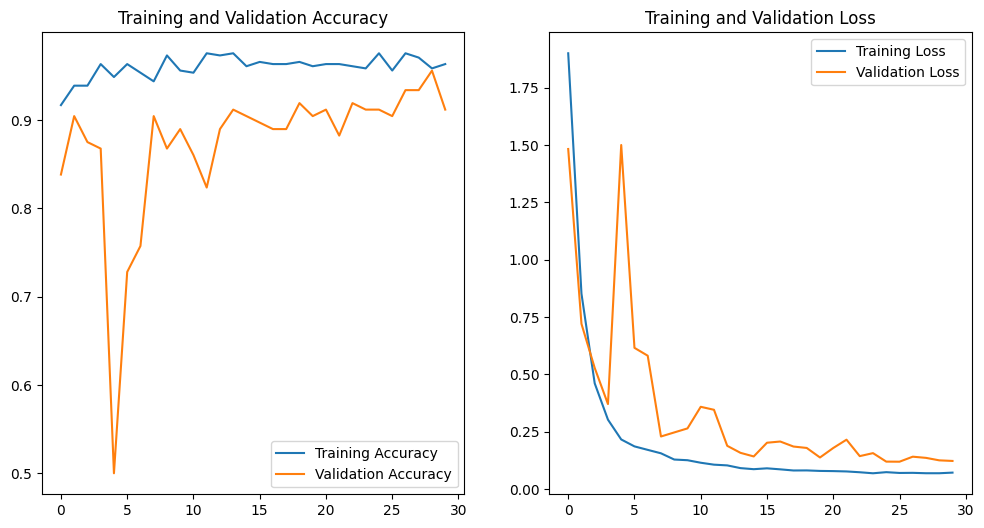

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8526 - loss: 0.1435
Testing Loss: 0.12657609581947327, Testing Accuracy: 0.9020978808403015


In [21]:
# class_weight = {0: 0.85, 1: 1.2}  # Sesuaikan bobot berdasarkan kinerja kelas

# Melatih model dan mencatat hasil pelatihan dalam objek `history`
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
    # class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler] 
)

# Menampilkan metrik dengan matplotlib
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model pada data testing
loss, accuracy = model.evaluate(ds_test)
print(f'Testing Loss: {loss}, Testing Accuracy: {accuracy}')


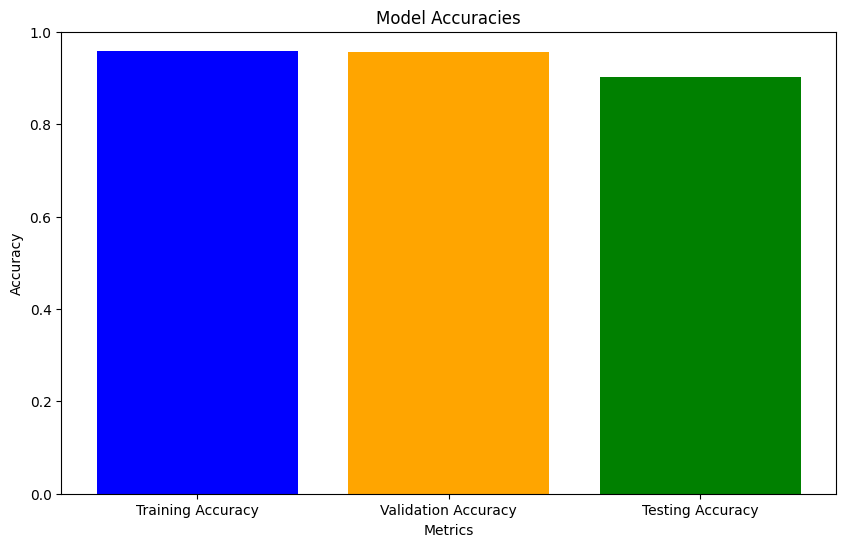

In [29]:
# Ambil nilai akurasi pada epoch terbaik
best_epoch = np.argmax(history.history['val_accuracy'])

train_accuracy = history.history['accuracy'][best_epoch] 
val_accuracy = history.history['val_accuracy'][best_epoch]

# Akurasi data testing (sudah didapat dari evaluasi model sebelumnya)
test_accuracy = accuracy

# Buat bar chart
labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, val_accuracy, test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  # Atur batas y dari 0 sampai 1
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step


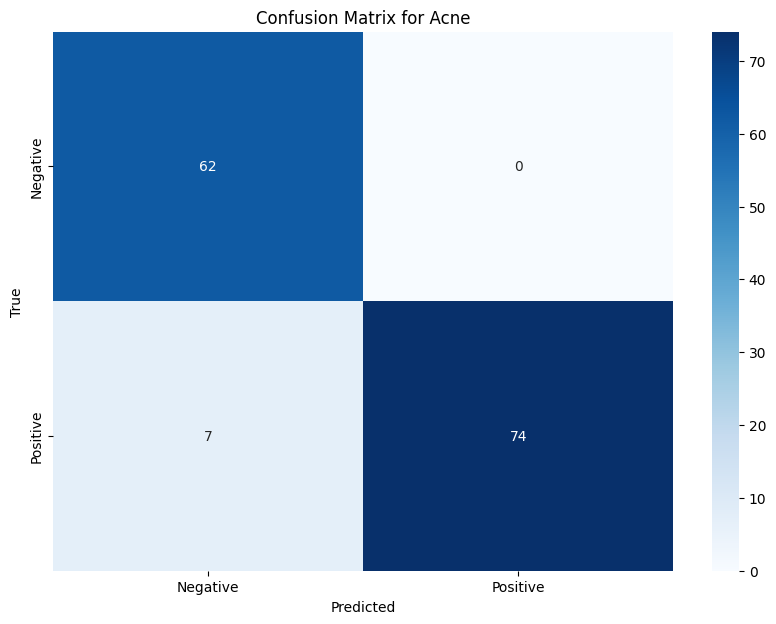

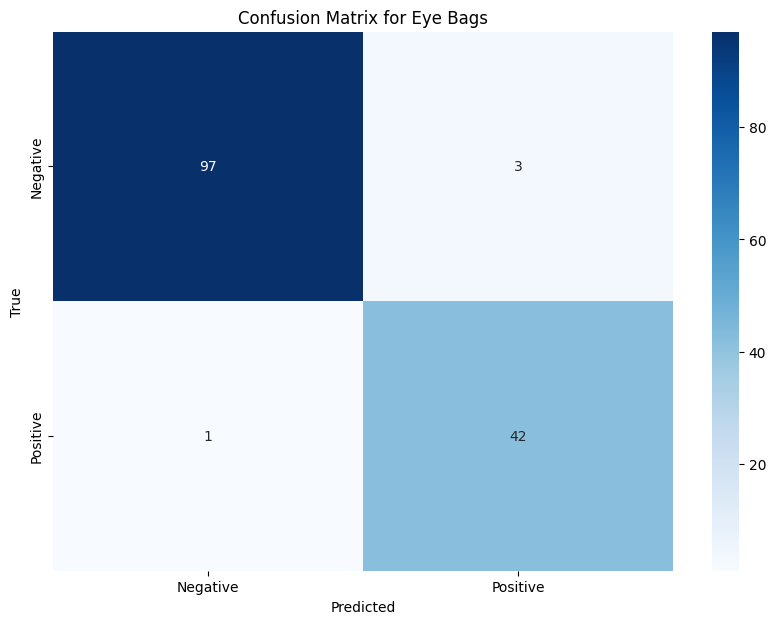

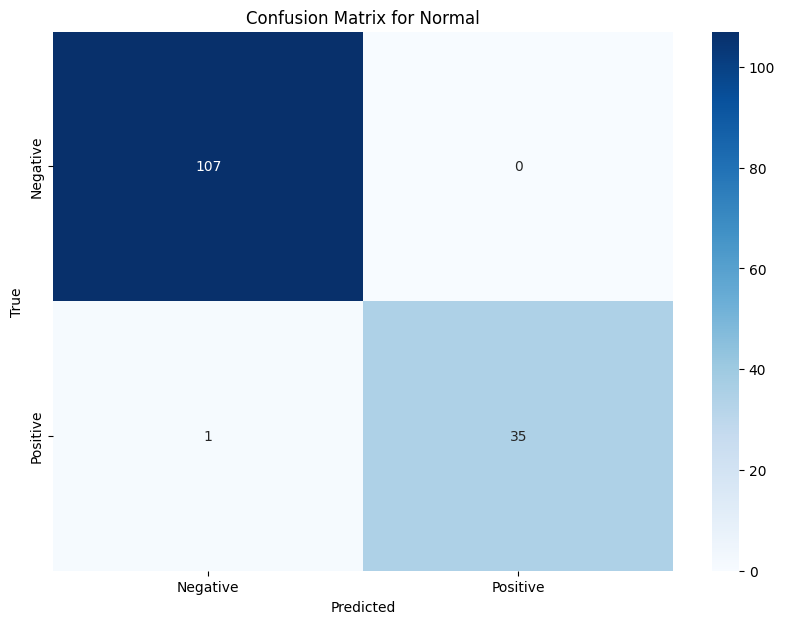

              precision    recall  f1-score   support

        Acne       1.00      0.91      0.95        81
    Eye Bags       0.93      0.98      0.95        43
      Normal       1.00      0.97      0.99        36

   micro avg       0.98      0.94      0.96       160
   macro avg       0.98      0.95      0.97       160
weighted avg       0.98      0.94      0.96       160
 samples avg       0.98      0.96      0.97       160



In [23]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_binary = (y_pred > 0.5).astype(int)  

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)

# Menghitung multilabel confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred_binary)

# Menampilkan confusion matrix untuk masing-masing label
labels = ['Acne', 'Eye Bags', 'Normal']
for i, label in enumerate(labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true, y_pred_binary, target_names=labels))

In [34]:
model.save(models_path + 'skin_conditions_model.h5')

In [31]:
import tensorflow as tf

# Load model dari file .keras
model = tf.keras.models.load_model(models_path + 'skin_conditions_model.keras')

# Buat converter untuk mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open(models_path + 'skin_conditions_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmp1sh9sg_k\assets


INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmp1sh9sg_k\assets


Saved artifact at 'C:\Users\albia\AppData\Local\Temp\tmp1sh9sg_k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2503663866448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663864912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663867984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663866832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663866640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663868176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663870480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663870672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663869136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2503663868944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  250366